#                                  Trinity Assignment

## Twitter Sentiment Analysis and Emotion Tagging

In [1]:
# First of all, let's import the data and specify all imports we will use in this kernel.

import pandas as pd
import numpy as np
from collections import Counter
import re
import copy
import json

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords

#get gender by name
import gender_guesser.detector as gender

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV
from textblob import TextBlob

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
%matplotlib inline
sns.set()

C:\Users\Sawan\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# setting display width for pandas column
pd.set_option('display.max_colwidth', -1)

tweet_lst = []
tweet_dict = {}

with open('tweets.json', 'r') as fh:
    for line in fh:
        tweet = json.loads(line)
        tweet_dict["id"] = tweet["id"]
        tweet_dict["tweet"] = tweet["text"]
        tweet_dict["name"] = tweet["user"]["name"]
        tweet_lst.append(copy.deepcopy(tweet_dict))
test_data = pd.DataFrame(tweet_lst)
test_data.head()

,id,name,tweet
0,593891099434983425,Silver Shoes,RT @KirkKus: Indirect cost of the UK being in the EU is estimated to be costing Britain £170 billion per year! #BetterOffOut #UKIP
1,593891099548094465,Raymond Jones,VIDEO: Sturgeon on post-election deals http://t.co/BTJwrpbmOY
2,593891099388846080,kate,RT @LabourEoin: The economy was growing 3 times faster on the day David Cameron became Prime Minister than it is today.. #BBCqt http://t.co…
3,593891100429045760,Rachel,RT @GregLauder: the UKIP east lothian candidate looks about 16 and still has an msn addy http://t.co/7eIU0c5Fm1
4,593891100768784384,Stuart,RT @thesundaypeople: UKIP's housing spokesman rakes in £800k in housing benefit from migrants. http://t.co/GVwb9Rcb4w http://t.co/c1AZxcLh…


In [3]:
# Cleaning the data

test_data['cleaned_tweet'] = test_data['tweet'].replace(r'#\w*','',regex = True)
test_data['cleaned_tweet'] = test_data['cleaned_tweet'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
test_data['cleaned_tweet'] = test_data['cleaned_tweet'].replace("  ", " ")

words_remove = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what", "there","all","we",
                "one","the","a","an","of","or","in","for","by","on","but","is","in","a","not","with","as",
                "was","if","they","are","this","and","it","have","has","from","at","my","be","by","not","that","to",
                "from","com","org","like","likes","so","said","from","what","told","over","more","other",
                "have","last","with","this","that","such","when","been","says","will","also","where","why",
                "would","today", "in", "on", "you", "r", "d", "u", "hw","wat", "oly", "s", "b", "ht", 
                "rt", "p","the","th", "n", "was"]


def cleantext(df, words_to_remove = words_remove): 
    ### dont change the original tweet
    # remove emoticons form the tweets
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'<ed>','', regex = True)
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'\B<U+.*>|<U+.*>\B|<U+.*>','', regex = True)
    
    # convert tweets to lowercase
    df['cleaned_tweet'] = df['cleaned_tweet'].str.lower()
    
    #remove user mentions
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'^(@\w+)',"", regex=True)
    
    #remove 'rt' in the beginning
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'^(rt @)',"", regex=True)
    
    #remove_symbols
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'[^a-zA-Z0-9]', " ", regex=True)

    #remove punctuations 
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'[[]!"#$%\'()\*+,-./:;<=>?^_`{|}]+',"", regex = True)

    #remove_URL(x):
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'https.*$', "", regex = True)
    
    #remove_URL(x):
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'http.*$', "", regex = True)

    #remove 'amp' in the text
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'amp',"", regex = True)
    
    #remove words of length 1 or 2 
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'\b[a-zA-Z]{1,2}\b','', regex=True)

    #remove extra spaces in the tweet
    df['cleaned_tweet'] = df['cleaned_tweet'].replace(r'^\s+|\s+$'," ", regex=True)
     
    
    #remove stopwords and words_to_remove
    stop_words = set(stopwords.words('english'))
    mystopwords = [stop_words, "via", words_to_remove]
    
    df['fully_cleaned_tweet'] = df['cleaned_tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in mystopwords]))
    

    return df


#get the processed tweets
test_data = cleantext(test_data)
test_data["text"] = test_data["fully_cleaned_tweet"]
print(test_data.shape)

# droping the duplicates tweet or the retweeted data
test_data = test_data.drop_duplicates(subset='fully_cleaned_tweet', keep="last")
print(test_data.shape)

test_data.head()


C:\Users\Sawan\Anaconda3\lib\site-packages\pandas\core\dtypes\inference.py:244: FutureWarning: Possible nested set at position 1
  re.compile(obj)


(20000, 6)
(9712, 6)


,id,name,tweet,cleaned_tweet,fully_cleaned_tweet,text
0,593891099434983425,Silver Shoes,RT @KirkKus: Indirect cost of the UK being in the EU is estimated to be costing Britain £170 billion per year! #BetterOffOut #UKIP,kirkkus indirect cost the being the estimated costing britain 170 billion per year,kirkkus indirect cost the being the estimated costing britain 170 billion per year,kirkkus indirect cost the being the estimated costing britain 170 billion per year
3,593891100429045760,Rachel,RT @GregLauder: the UKIP east lothian candidate looks about 16 and still has an msn addy http://t.co/7eIU0c5Fm1,greglauder the ukip east lothian candidate looks about 16 and still has msn addy,greglauder the ukip east lothian candidate looks about 16 and still has msn addy,greglauder the ukip east lothian candidate looks about 16 and still has msn addy
6,593891101154619392,moosehead,RT @joannetallis: Ed Milliband is an embarrassment. Would you want him representing the UK?! #bbcqt vote @Conservatives,joannetallis milliband embarrassment would you want him representing the vote conservatives,joannetallis milliband embarrassment would you want him representing the vote conservatives,joannetallis milliband embarrassment would you want him representing the vote conservatives
8,593891101838340096,Richard Harding,RT @NivenJ1: “@George_Osborne: Ed Miliband proved tonight why he's not up to the job” Tbf you've spent 5 years doing that you salivating do…,nivenj1 george osborne miliband proved tonight why hes not the job tbf youve spent 5 years doing that you salivating,nivenj1 george osborne miliband proved tonight why hes not the job tbf youve spent 5 years doing that you salivating,nivenj1 george osborne miliband proved tonight why hes not the job tbf youve spent 5 years doing that you salivating
9,593891101313896449,Phyllis de Vatois,LOLZ to Trickle Down Wealth. It's never trickling past their own wallets. Greed always wins $$$ for the greedy. https://t.co/X7deoPbS97,lolz trickle down wealth its never trickling past their own wallets greed always wins for the greedy,lolz trickle down wealth its never trickling past their own wallets greed always wins for the greedy,lolz trickle down wealth its never trickling past their own wallets greed always wins for the greedy


### Classify the users into Male, Female, Organization or Uncategorized

In [4]:
d = gender.Detector(case_sensitive=False)
def getGender(name):
    try:
        u_name_list = ["1","2","3","4","5","6","7","8","9","0","@", "#","$","_"]
        category = d.get_gender(str(name).split(" ")[0])
        if category == "male" or category == "female":
            return category
        elif category == "mostly_male" or category == "mostly_female" or category == "unknown":
            for i in u_name_list:
                if i in list(name):
                    return "uncategorized"
            else:
                return "organization"
    except:
        return "uncategorized"
test_data["category"] = test_data["name"].apply(lambda x: getGender(x))
test_data.head()

,id,name,tweet,cleaned_tweet,fully_cleaned_tweet,text,category
0,593891099434983425,Silver Shoes,RT @KirkKus: Indirect cost of the UK being in the EU is estimated to be costing Britain £170 billion per year! #BetterOffOut #UKIP,kirkkus indirect cost the being the estimated costing britain 170 billion per year,kirkkus indirect cost the being the estimated costing britain 170 billion per year,kirkkus indirect cost the being the estimated costing britain 170 billion per year,male
3,593891100429045760,Rachel,RT @GregLauder: the UKIP east lothian candidate looks about 16 and still has an msn addy http://t.co/7eIU0c5Fm1,greglauder the ukip east lothian candidate looks about 16 and still has msn addy,greglauder the ukip east lothian candidate looks about 16 and still has msn addy,greglauder the ukip east lothian candidate looks about 16 and still has msn addy,female
6,593891101154619392,moosehead,RT @joannetallis: Ed Milliband is an embarrassment. Would you want him representing the UK?! #bbcqt vote @Conservatives,joannetallis milliband embarrassment would you want him representing the vote conservatives,joannetallis milliband embarrassment would you want him representing the vote conservatives,joannetallis milliband embarrassment would you want him representing the vote conservatives,organization
8,593891101838340096,Richard Harding,RT @NivenJ1: “@George_Osborne: Ed Miliband proved tonight why he's not up to the job” Tbf you've spent 5 years doing that you salivating do…,nivenj1 george osborne miliband proved tonight why hes not the job tbf youve spent 5 years doing that you salivating,nivenj1 george osborne miliband proved tonight why hes not the job tbf youve spent 5 years doing that you salivating,nivenj1 george osborne miliband proved tonight why hes not the job tbf youve spent 5 years doing that you salivating,male
9,593891101313896449,Phyllis de Vatois,LOLZ to Trickle Down Wealth. It's never trickling past their own wallets. Greed always wins $$$ for the greedy. https://t.co/X7deoPbS97,lolz trickle down wealth its never trickling past their own wallets greed always wins for the greedy,lolz trickle down wealth its never trickling past their own wallets greed always wins for the greedy,lolz trickle down wealth its never trickling past their own wallets greed always wins for the greedy,female


## Add Sentiment for each tweet using text blob

### First lets see how textblob works

In [5]:
# See how text blob works

print(TextBlob("Today India played very good in finals").sentiment.polarity)
print(TextBlob("Dhoni is best caption").sentiment.polarity)
print(TextBlob("Today yuvraj performance was worst in his entire carrier").sentiment.polarity)

0.9099999999999999
1.0
-0.5


C:\Users\Sawan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


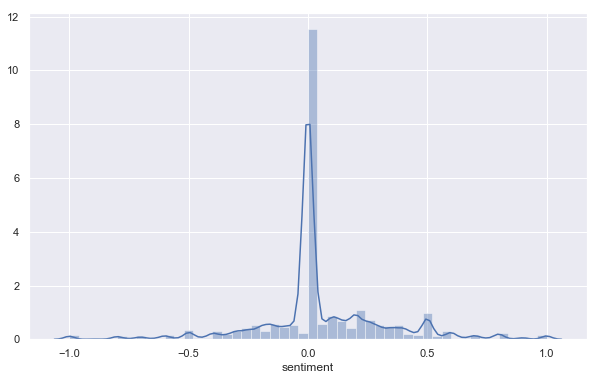

In [7]:
test_data['sentiment'] = test_data['fully_cleaned_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)  #-1 to 1

sns.set(rc={"figure.figsize": (10, 6)})

sns.distplot(test_data['sentiment'], norm_hist=True)

####  In above plot we can see maximum tweets are neutral an a little biased towards positive, very less -ve we hav

## Above all classification is telling us  +ve, -ve and neutral behaviour of the people.
### Now we need to identify the emotions like happy, sad, anger 
### For this classification we need some training data to train our model. For this we are going to take a corpus from NRC Word-Emotion Association Lexicon
[NRC Word-Emotion Association Lexicon](https://saifmohammad.com/WebPages/NRC-Emotion-Lexicon.htm)

### And link for data is
[Emotions tagged tweets lexicon](https://saifmohammad.com/WebDocs/Jan9-2012-tweets-clean.txt.zip)

In [8]:
# First of all, let's import the training data

cl = ["id", "tweet", "emotion"]
df =pd.read_csv("Jan9-2012-tweets-clean.txt", delimiter="\t", encoding="utf8", error_bad_lines=False, header=None, names = cl)
df["emotion"] = df.emotion.apply(lambda x: str(x).replace("::",""))
df = df.drop_duplicates(subset='tweet', keep="last")
df = df.drop("id", axis=1)
df.head()

,tweet,emotion
0,Thinks that @melbahughes had a great 50th birthday party :),surprise
1,"Como una expresión tan simple, una sola oración, puede llegara dañarte tanto.",sadness
2,the moment when you get another follower and you cheer.,joy
3,Be the greatest dancer of your life! practice daily positive habits. #fun #freedom #habits,joy
4,eww.. my moms starting to make her annual rum cake for the whole ramdyal/ally family. fml fml fml the smelll.......,disgust


## Feature Inspection 
#### In order to get some feeling for the data we are going to work with, we will start out with a quick exploratory phase. We will have a look at a couple of things. For example how many documents (I will define one entry in the text column as a document) we have per writer. Look at the lengths of the documents. Look at some (in)frequent words that are used.

#### This exploratory phase is always a good thing to start with to get an idea of the data and it will probably help you out making decisions later on in the process of any data science problem you have and in particular now for text classification.

In [9]:
df.emotion.value_counts()

 joy           8139
 sadness       3829
 surprise      3802
 fear          2503
 anger         1527
 disgust       760 
ribbon :)      1   
out of life    1   
Run!           1   
nan            1   
Name: emotion, dtype: int64

In [10]:
# drop all the invalid emotions
df["emotion"] = df["emotion"].apply(lambda x: x.strip())
i = df[(df.emotion == 'out of life')].index
df = df.drop(i)
i = df[(df.emotion == 'ribbon :)')].index
df = df.drop(i)
i = df[(df.emotion == 'nan')].index
df = df.drop(i)
i = df[(df.emotion == 'Run!')].index
df = df.drop(i)

In [11]:
# clean the data
df['cleaned_tweet'] = df['tweet'].replace(r'\'|\"|\,|\.|\?|\+|\-|\/|\=|\(|\)|\n|"', '', regex=True)
df['cleaned_tweet'] = df['cleaned_tweet'].replace("  ", " ")
df = cleantext(df)
df["text"] = df["fully_cleaned_tweet"]
df.head()

,tweet,emotion,cleaned_tweet,fully_cleaned_tweet,text
0,Thinks that @melbahughes had a great 50th birthday party :),surprise,thinks that melbahughes had great 50th birthday party,thinks that melbahughes had great 50th birthday party,thinks that melbahughes had great 50th birthday party
1,"Como una expresión tan simple, una sola oración, puede llegara dañarte tanto.",sadness,como una expresi tan simple una sola oraci puede llegara arte tanto,como una expresi tan simple una sola oraci puede llegara arte tanto,como una expresi tan simple una sola oraci puede llegara arte tanto
2,the moment when you get another follower and you cheer.,joy,the moment when you get another follower and you cheer,the moment when you get another follower and you cheer,the moment when you get another follower and you cheer
3,Be the greatest dancer of your life! practice daily positive habits. #fun #freedom #habits,joy,the greatest dancer your life practice daily positive habits fun freedom habits,the greatest dancer your life practice daily positive habits fun freedom habits,the greatest dancer your life practice daily positive habits fun freedom habits
4,eww.. my moms starting to make her annual rum cake for the whole ramdyal/ally family. fml fml fml the smelll.......,disgust,eww moms starting make her annual rum cake for the whole ramdyalally family fml fml fml the smelll,eww moms starting make her annual rum cake for the whole ramdyalally family fml fml fml the smelll,eww moms starting make her annual rum cake for the whole ramdyalally family fml fml fml the smelll


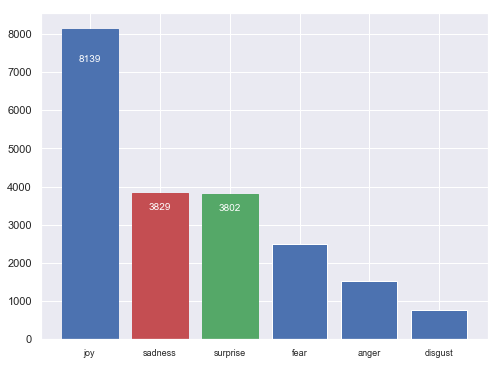

In [12]:
fig, ax = plt.subplots(1,1,figsize=(8,6))

author_vc = df.emotion.value_counts()

ax.bar(range(6), author_vc)
ax.set_xticks(range(6))
ax.set_xticklabels(author_vc.index, fontsize=9)

for rect, c, value in zip(ax.patches, ['b', 'r', 'g'], author_vc.values):
    rect.set_color(c)
    height = rect.get_height()
    width = rect.get_width()
    x_loc = rect.get_x()
    ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='center', fontsize=10, color='white')

### Inspect text variable

In [14]:
document_lengths = np.array(list(map(len, df.text.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 11.540369649805447.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 27.


#### Note how there's actually a document with just two words. That is going to be interesting to classify. Let's dig in a little bit deeper and see the distribution of the number of words in a document.

C:\Users\Sawan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


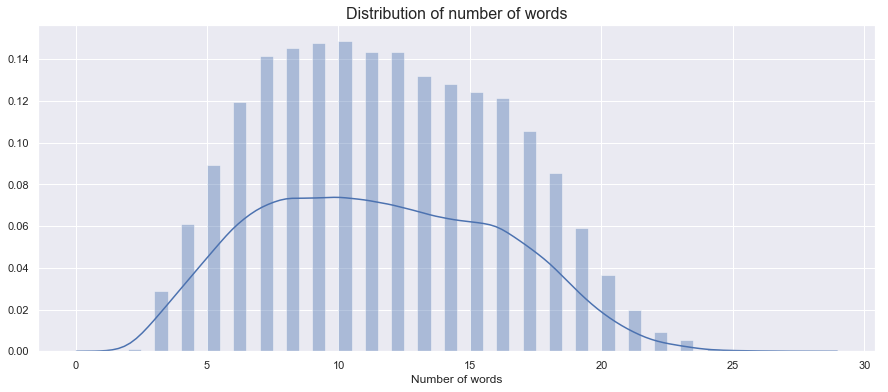

In [15]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax);

## Feature creation 
### The usual approach in natural language processing, is to first kind of cleanse the text. We have to make sure our model can understand similarities and understand when two different words mean similar things. You can't just input the raw text into a model and expect it to understand everything. Therefore, I summarized the most common steps to take in order to achieve this cleansing.

In [16]:
# A little codeblock specifically meant for word2vec

def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(df)

#### So we're actually already finished the word2vec preprocessing! All the following steps are preprocessing steps for LDA.

In [17]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(df)

#### Let's view at the top word frequencies now and get an idea of the words that are used mostly.

In [18]:
tokenized_only_dict = Counter(np.concatenate(df.tokenized_text.values))

tokenized_only_df = pd.DataFrame.from_dict(tokenized_only_dict, orient='index')
tokenized_only_df.rename(columns={0: 'count'}, inplace=True)

Text(0.5,1,'Word Frequencies')

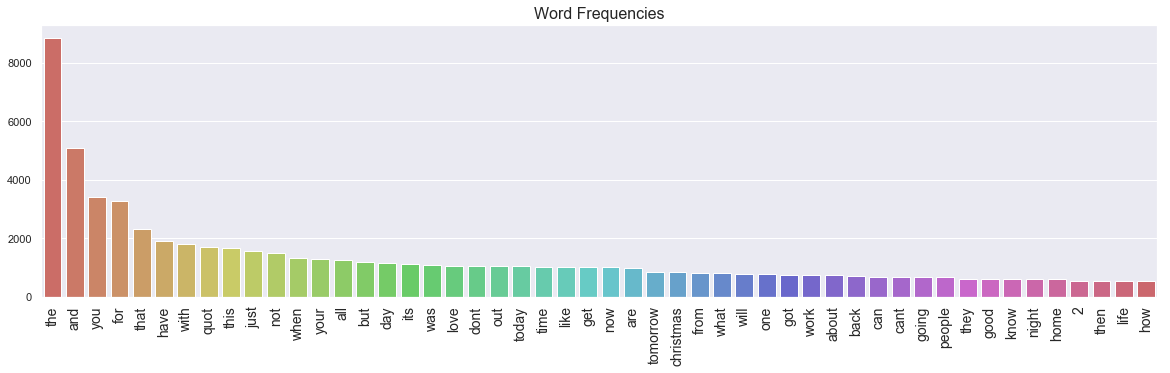

In [19]:
tokenized_only_df.sort_values('count', ascending=False, inplace=True)

# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df)
ax.set_title("Word Frequencies", fontsize=16)

#### It was to be expected that simple words like 'the', 'and' and 'you' are words that are used often. Unless you think that one author would preferably use on of these words more often than other authors, it's safe to remove these words. Like we stated in point 2 above, we will remove frequent words and stopwords since they probably bring little meaning and maybe even create noise when we want to classify later on.

### Remove words that mean little
#### As stated above, words the have little meaning to the model are words we'd like to remove. Moreover, these words can create noise which can make it harder to classify the texts later on.

In [20]:
our_special_word = 'qwerty'
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(df)

### Stemming
#### For the stemming part, we'll start with lemmatization, this will stem words like leaves to leaf. Afterwards, we'll apply the porterstemmer which in turn will complete the stemming by converting words like running to run.

In [21]:
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(df)

### Vectorize words
#### Here we create a dictionary for the model. Since a computer can't reallly understand what a word means, we need to transform it into some number the model will be able to work with. We use gensim.corpora.Dictionary for this.

In [22]:
dictionary = Dictionary(documents=df.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 25168 words.


In [23]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 5757 words.


#### I decided to remove only the top 20% of words since we're dealing with a relatively small dataset here. Also words that occur less than 3 times are removed.

In [24]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(df)

# we make a function such that later on when we make the submission, we don't need to write duplicate code
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    stem_words(df)
    document_to_bow(df)


### Visualize the cleansed words frequencies
#### Excellent! We cleansed our data and are ready to continue with LDA and Word2Vec, but before we do that, I would like to visualize the cleansed results and see what we created so far.

In [ ]:
cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

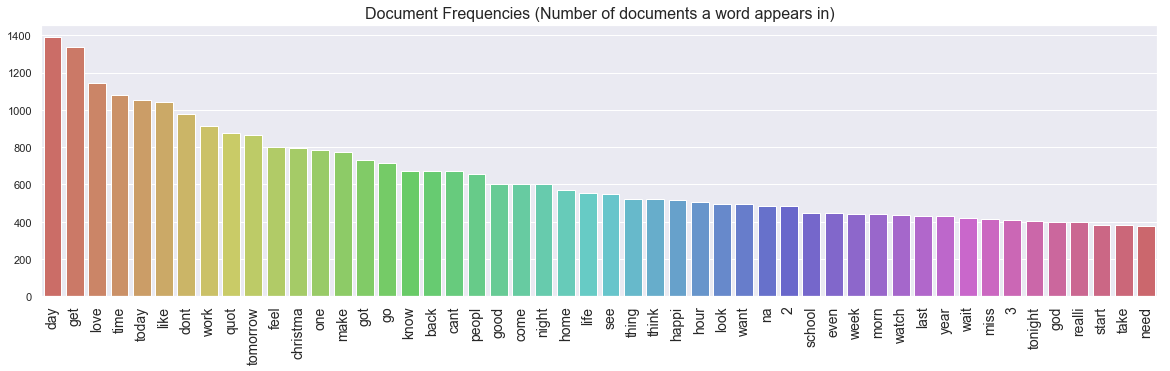

In [25]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16);

In [27]:
df.head(2)

,tweet,emotion,cleaned_tweet,fully_cleaned_tweet,text,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,lemmatized_text,stemmed_text,bow
0,Thinks that @melbahughes had a great 50th birthday party :),surprise,thinks that melbahughes had great 50th birthday party,thinks that melbahughes had great 50th birthday party,thinks that melbahughes had great 50th birthday party,[thinks that melbahughes had great 50th birthday party],"[[thinks, that, melbahughes, had, great, 50th, birthday, party]]","[thinks, that, melbahughes, had, great, 50th, birthday, party]","[thinks, melbahughes, great, 50th, birthday, party]","[think, melbahughes, great, 50th, birthday, party]","[think, melbahugh, great, 50th, birthday, parti]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]"
1,"Como una expresión tan simple, una sola oración, puede llegara dañarte tanto.",sadness,como una expresi tan simple una sola oraci puede llegara arte tanto,como una expresi tan simple una sola oraci puede llegara arte tanto,como una expresi tan simple una sola oraci puede llegara arte tanto,[como una expresi tan simple una sola oraci puede llegara arte tanto],"[[como, una, expresi, tan, simple, una, sola, oraci, puede, llegara, arte, tanto]]","[como, una, expresi, tan, simple, una, sola, oraci, puede, llegara, arte, tanto]","[como, una, expresi, tan, simple, una, sola, oraci, puede, llegara, arte, tanto]","[como, una, expresi, tan, simple, una, sola, oraci, puede, llegara, arte, tanto]","[como, una, expresi, tan, simpl, una, sola, oraci, pued, llegara, art, tanto]","[(5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2)]"


## Model Training 
### LDA
#### Latent Dirichlet Allocation (LDA) is generative approach in classifying texts. It is a three level hierarchical Bayesian model where it creates probabilities on word level, on document level and on corpus level (corpus means all documents). The objective function looks pretty complex, but it's just a way of describing the probability of a corpus:

### LDA training

In [28]:
corpus = df.bow

In [29]:
%%time
num_topics = 150
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=4,
                        chunksize=4000,
                        passes=7,
                        alpha='asymmetric')

C:\Users\Sawan\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Wall time: 35.4 s


### LDA topic inspection
#### Let's first create the feature vectors.

In [30]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

df['lda_features'] = list(map(lambda doc:
                                      document_to_lda_features(LDAmodel, doc),
                                      df.bow))

In [31]:
Joy_topic_distribution = df.loc[df.emotion == 'joy', 'lda_features'].mean()
Surptise_topic_distribution = df.loc[df.emotion == 'surprise', 'lda_features'].mean()
Disgust_topic_distribution = df.loc[df.emotion == 'disgust', 'lda_features'].mean()
Sadness_topic_distribution = df.loc[df.emotion == 'sadness', 'lda_features'].mean()
Anger_topic_distribution = df.loc[df.emotion == 'anger', 'lda_features'].mean()
Fear_topic_distribution = df.loc[df.emotion == 'fear', 'lda_features'].mean()

In [32]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model.
    """
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [33]:
for author, distribution in zip(['joy', 'surprise', 'disgust','sadness', 'anger', 'fear'], [Joy_topic_distribution, Surptise_topic_distribution, Disgust_topic_distribution, Sadness_topic_distribution, Anger_topic_distribution, Fear_topic_distribution]):
    print("Looking up top words from top topics from {}.".format(author))
    for x in sorted(np.argsort(distribution)[-5:]):
        top_words = get_topic_top_words(LDAmodel, x)
        print("For topic {}, the top words are: {}.".format(x, ", ".join(top_words)))
    print("")

Looking up top words from top topics from joy.
For topic 70, the top words are: need, life, fun, xma, hear.
For topic 85, the top words are: christma, tree, season, present, decor.
For topic 101, the top words are: wait, anoth, cant, 7, yet.
For topic 117, the top words are: hour, 4, shop, full, half.
For topic 126, the top words are: final, sleep, 3, wake, hour.

Looking up top words from top topics from surprise.
For topic 72, the top words are: met, voor, een, van, maken.
For topic 75, the top words are: weekend, haha, shirt, cousin, bo.
For topic 128, the top words are: birthday, left, parti, fire, mother.
For topic 135, the top words are: een, van, dat, song, heb.
For topic 148, the top words are: surpris, 1, pa, mon, number.

Looking up top words from top topics from disgust.
For topic 3, the top words are: make, fuckin, tri, thing, good.
For topic 78, the top words are: dad, girl, sinc, lord, 30.
For topic 86, the top words are: hate, ill, school, phone, hard.
For topic 131, the

### Word2Vec
#### Word2vec is a deep learning method for creating vector representations of words. There are basically two word2vec approaches: continuous skip-gram modeling (SG) or continuous bag of words (CBOW). Both create word vector representations, but with different approaches.

#### Word2Vec training

In [36]:
sentences = []
for sentence_group in df.tokenized_sentences:
    sentences.extend(sentence_group)

In [37]:
%%time
# Set values for various parameters
num_features = 200    # Word vector dimensionality
min_word_count = 3    # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 6           # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

Wall time: 3.41 s


### Word2Vec feature inspection
#### Let's first create the word2vec features.

In [38]:
def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

df['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      df.tokenized_sentences))

C:\Users\Sawan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


### Classification and hyperparameter tuning
#### We have come far now! At this point we transformed the documents we had into features we can use to train our final models. We used LDA and Word2Vec to extract sensible feature data from the documents. Now we're going to apply a few supervised classifiers to be able to predict what text belongs to which emotion.

In [39]:
label_encoder = LabelEncoder()

label_encoder.fit(df.emotion)
df['emotion_id'] = label_encoder.transform(df.emotion)

In [40]:
def get_cross_validated_model(model, param_grid, X, y, nr_folds=5):
    """ Trains a model by doing a grid search combined with cross validation.
    args:
        model: your model
        param_grid: dict of parameter values for the grid search
    returns:
        Model trained on entire dataset with hyperparameters chosen from best results in the grid search.
    """
    # train the model (since the evaluation is based on the logloss, we'll use neg_log_loss here)
    grid_cv = GridSearchCV(model, param_grid=param_grid, scoring='neg_log_loss', cv=nr_folds, n_jobs=-1, verbose=True)
    best_model = grid_cv.fit(X, y)
    # show top models with parameter values
    result_df = pd.DataFrame(best_model.cv_results_)
    show_columns = ['mean_test_score', 'mean_train_score', 'rank_test_score']
    for col in result_df.columns:
        if col.startswith('param_'):
            show_columns.append(col)
    display(result_df[show_columns].sort_values(by='rank_test_score').head())
    return best_model

In [41]:
# since train_data['lda_features'] and train_data['w2v_features'] don't have the needed shape and type yet,
# we first have to transform every entry
X_train_lda = np.array(list(map(np.array, df.lda_features)))
X_train_w2v = np.array(list(map(np.array, df.w2v_features)))
X_train_combined = np.append(X_train_lda, X_train_w2v, axis=1)

#### Note: since we are dealing with log loss and not simply accuracy, we have to choose models that support the method predict_proba. If you're interested in what classifiers in the sklearn package support this method, you can execute the next cell.

##### from sklearn.utils.testing import all_estimators
###### estimators = all_estimators()
##### for name, class in estimators: if hasattr(class, 'predict_proba'): print(name)

In [42]:
# store all models in a dictionary
models = dict()

In [43]:
# LDA features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_lda = get_cross_validated_model(lr, param_grid, X_train_lda, df.emotion_id)

models['best_lr_lda'] = best_lr_lda

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   21.7s finished
C:\Users\Sawan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sawan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sawan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args,

,mean_test_score,mean_train_score,rank_test_score,param_penalty
0,-1.429751,-1.399955,1,l1
1,-1.431942,-1.405334,2,l2


In [44]:
# Word2Vec features only
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_w2v = get_cross_validated_model(lr, param_grid, X_train_w2v, df.emotion_id)

models['best_lr_w2v'] = best_lr_w2v

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.1min finished
C:\Users\Sawan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sawan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sawan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args,

,mean_test_score,mean_train_score,rank_test_score,param_penalty
0,-1.297046,-1.286023,1,l1
1,-1.300440,-1.290409,2,l2


In [45]:
# LDA and Word2Vec combined
lr = LogisticRegression()

param_grid = {'penalty': ['l1', 'l2']}

best_lr_combined = get_cross_validated_model(lr, param_grid, X_train_combined, df.emotion_id)

models['best_lr_combined'] = best_lr_combined

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.3min finished
C:\Users\Sawan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sawan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Sawan\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args,

,mean_test_score,mean_train_score,rank_test_score,param_penalty
0,-1.271167,-1.236991,1,l1
1,-1.271373,-1.237408,2,l2


### Model Selection ¶
#### Now let's get clear what model performed best.

In [47]:
for name, model in models.items():
    print("Model {} has a test score of: {:0.4f}".format(name, float(model.best_score_)))

Model best_lr_lda has a test score of: -1.4298
Model best_lr_w2v has a test score of: -1.2970
Model best_lr_combined has a test score of: -1.2712


#### Thus logistic regression with combined LDA and word2vec features wins!

### Now we come to the point where we can make predictions

In [49]:
# see test data
test_data.head(2)

,id,name,tweet,cleaned_tweet,fully_cleaned_tweet,text,category,sentiment
0,593891099434983425,Silver Shoes,RT @KirkKus: Indirect cost of the UK being in the EU is estimated to be costing Britain £170 billion per year! #BetterOffOut #UKIP,kirkkus indirect cost the being the estimated costing britain 170 billion per year,kirkkus indirect cost the being the estimated costing britain 170 billion per year,kirkkus indirect cost the being the estimated costing britain 170 billion per year,male,0.0
3,593891100429045760,Rachel,RT @GregLauder: the UKIP east lothian candidate looks about 16 and still has an msn addy http://t.co/7eIU0c5Fm1,greglauder the ukip east lothian candidate looks about 16 and still has msn addy,greglauder the ukip east lothian candidate looks about 16 and still has msn addy,greglauder the ukip east lothian candidate looks about 16 and still has msn addy,female,0.0


#### Let's repeat our preprocessing steps now.  we made a nice preprocessing functions above that does everything for us now.

In [50]:
lda_preprocessing(test_data)
w2v_preprocessing(test_data)

In [51]:
test_data['lda_features'] = list(map(lambda doc:
                                     document_to_lda_features(LDAmodel, doc),
                                     test_data.bow))

test_data = test_data[test_data.astype(str)['tokenized_sentences'] != '[]']
test_data['w2v_features'] = list(map(lambda sen_group:
                                     get_w2v_features(W2Vmodel, sen_group),
                                     test_data.tokenized_sentences))

C:\Users\Sawan\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  app.launch_new_instance()


In [52]:
df['emotion_id'] = label_encoder.transform(df.emotion)

In [53]:
X_test_lda = np.array(list(map(np.array, test_data.lda_features)))
X_test_w2v = np.array(list(map(np.array, test_data.w2v_features)))
X_test_combined = np.append(X_test_lda, X_test_w2v, axis=1)

### Now it's time to make the classifications.

In [54]:
submission_predictions = best_lr_combined.predict_proba(X_test_combined)

In [55]:
label_encoder.classes_

array(['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'],
      dtype=object)

In [56]:
result = np.append(test_data.text.values.reshape(-1,1), submission_predictions, axis=1)

In [57]:
submission_df = pd.DataFrame(data=result, columns=['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise'])

In [74]:
submission_df[['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']] = submission_df[['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']].astype(float)
submission_df["emotion"] = submission_df[['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']].idxmax(axis=1)

In [75]:
submission_df.head()

,text,anger,disgust,fear,joy,sadness,surprise,emotion
0,kirkkus indirect cost the being the estimated costing britain 170 billion per year,0.030173,0.040721,0.178593,0.524151,0.102776,0.123587,joy
1,greglauder the ukip east lothian candidate looks about 16 and still has msn addy,0.058808,0.033388,0.105170,0.589311,0.153710,0.059614,joy
2,joannetallis milliband embarrassment would you want him representing the vote conservatives,0.200689,0.057335,0.275664,0.078978,0.172030,0.215303,fear
3,nivenj1 george osborne miliband proved tonight why hes not the job tbf youve spent 5 years doing that you salivating,0.088482,0.036287,0.116287,0.250037,0.281013,0.227895,sadness
4,lolz trickle down wealth its never trickling past their own wallets greed always wins for the greedy,0.098240,0.067927,0.244308,0.255673,0.225384,0.108467,joy


### I have categorized emotions of tweets on basis of maximum probability score, but if we can set a threshold we can categorize tweets into multiple categories.